# Indian Domestic Flight Price Analysis

This notebook analyzes a dataset of flight prices to uncover key cost drivers. The process includes:
1.  **ETL:** Loading and cleaning the flight data, including complex feature engineering on dates and duration.
2.  **EDA:** Visualizing price patterns across airlines, routes, and time.
3.  **Automated Reporting:** Generating a summary dashboard in Excel.

In [1]:
# Step 1: Import Libraries and Setup
import pandas as pd
import numpy as np
import os
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully.")

Libraries imported successfully.


## Step 2: ETL (Extract, Transform, Load)

We will load the local `Data_Train.xlsx` file, clean it, and engineer new features for analysis.

In [3]:
# --- 1. EXTRACTION ---
SOURCE_FILE = 'data/Data_Train.csv'

print(f"Loading dataset from '{SOURCE_FILE}'...")
try:
    df = pd.read_csv(SOURCE_FILE)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: '{SOURCE_FILE}' not found.")
    print("Please download the dataset from Kaggle and place it in the 'source_data' folder.")
    raise

# --- 2. TRANSFORMATION ---
print("\nStarting data cleaning and feature engineering...")

# Drop rows with missing values
df.dropna(inplace=True)

# Convert 'Date_of_Journey' to datetime and extract features
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], dayfirst=True)
df['Journey_Day'] = df['Date_of_Journey'].dt.day
df['Journey_Month'] = df['Date_of_Journey'].dt.month_name()

# Convert 'Duration' to total minutes
def convert_duration(duration):
    total_minutes = 0
    parts = duration.split(' ')
    for part in parts:
        if 'h' in part:
            total_minutes += int(part.replace('h', '')) * 60
        elif 'm' in part:
            total_minutes += int(part.replace('m', ''))
    return total_minutes

df['Duration_in_Mins'] = df['Duration'].apply(convert_duration)

# Clean up 'Airline' column
df['Airline'] = df['Airline'].replace('Vistara Premium economy', 'Vistara')

# Drop original columns that are no longer needed
df.drop(['Date_of_Journey', 'Dep_Time', 'Arrival_Time', 'Duration', 'Additional_Info'], axis=1, inplace=True)


# --- 3. LOADING ---
os.makedirs('data', exist_ok=True)
os.makedirs('output/eda_visuals', exist_ok=True)
CLEAN_DATA_PATH = 'data/flight_prices_clean.csv'
df.to_csv(CLEAN_DATA_PATH, index=False)
print(f"Cleaned data saved to '{CLEAN_DATA_PATH}'")

db_engine = create_engine('sqlite:///flight_analysis.sqlite')
df.to_sql('flights', db_engine, if_exists='replace', index=False)
print("Data loaded into 'flight_analysis.sqlite' database.")

print("\nCleaned Data Head:")
df.head()

Loading dataset from 'data/Data_Train.csv'...
Dataset loaded successfully.

Starting data cleaning and feature engineering...
Cleaned data saved to 'data/flight_prices_clean.csv'
Data loaded into 'flight_analysis.sqlite' database.

Cleaned Data Head:


,Airline,Source,Destination,Route,Total_Stops,Price,Journey_Day,Journey_Month,Duration_in_Mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,3897,24,March,170
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,7662,1,May,445
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,13882,9,June,1140
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,6218,12,May,325
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,13302,1,March,285


## Step 3: Exploratory Data Analysis (EDA)

Now we will visualize the data to understand the factors affecting flight prices.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14228\3185174519.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='Airline', x='Price', data=df.sort_values('Price', ascending=False), palette='viridis')


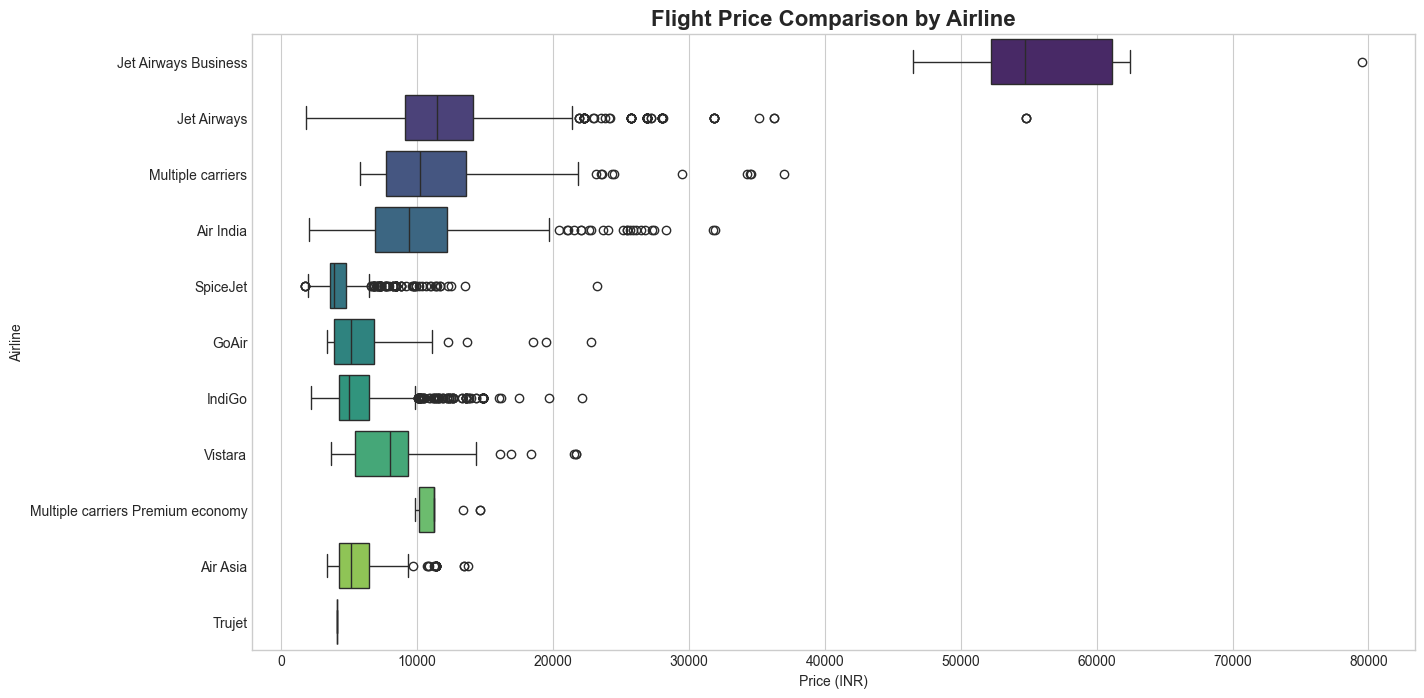

In [4]:
# Viz 1: Airline Price Comparison
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 8))
sns.boxplot(y='Airline', x='Price', data=df.sort_values('Price', ascending=False), palette='viridis')
plt.title('Flight Price Comparison by Airline', fontsize=16, fontweight='bold')
plt.xlabel('Price (INR)')
plt.ylabel('Airline')
plt.savefig('output/eda_visuals/airline_price_comparison.png')
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14228\128920581.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_prices.index, y=monthly_prices.values, palette='rocket')


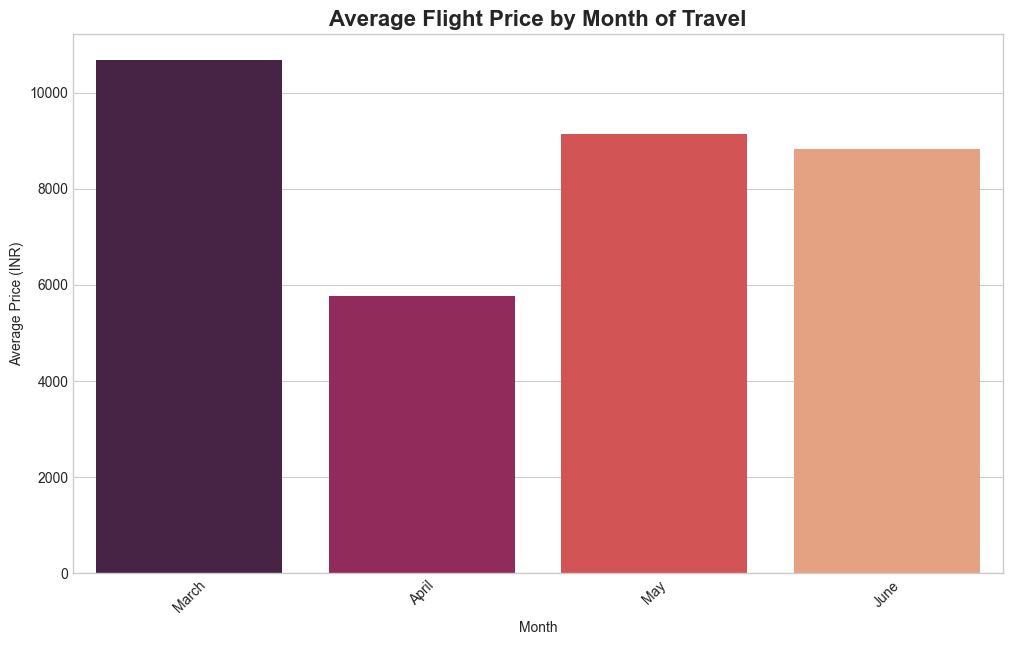

In [6]:
# Viz 2: Average Price by Month of Travel
monthly_prices = df.groupby('Journey_Month')['Price'].mean().sort_values(ascending=False)
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_prices = monthly_prices.reindex(month_order).dropna()

plt.figure(figsize=(12, 7))
sns.barplot(x=monthly_prices.index, y=monthly_prices.values, palette='rocket')
plt.title('Average Flight Price by Month of Travel', fontsize=16, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Price (INR)')
plt.xticks(rotation=45)
plt.savefig('output/eda_visuals/price_by_month.png')
plt.show()

## Step 4: Automated Excel Dashboard Creation

Finally, we automate the creation of a summary Excel dashboard.

In [7]:

# Automate the creation of the Excel Dashboard
print("Starting Excel Dashboard creation...")

EXCEL_PATH = 'output/Flight_Analysis_Dashboard.xlsx'

# --- Prepare Summaries ---
airline_summary = df.groupby('Airline')['Price'].mean().round(0).sort_values().reset_index()
airline_summary.rename(columns={'Price': 'Average_Price'}, inplace=True)

route_summary = df.groupby(['Source', 'Destination'])['Price'].mean().round(0).sort_values(ascending=False).head(10).reset_index()
route_summary.rename(columns={'Price': 'Average_Price'}, inplace=True)
route_summary['Route'] = route_summary['Source'] + ' to ' + route_summary['Destination']

# --- Create Excel File ---
with pd.ExcelWriter(EXCEL_PATH, engine='xlsxwriter') as writer:
    # Write summaries to a hidden sheet
    airline_summary.to_excel(writer, sheet_name='Summaries', startrow=0, startcol=0, index=False)
    route_summary.to_excel(writer, sheet_name='Summaries', startrow=0, startcol=3, index=False)
    
    # Get workbook and worksheet objects
    workbook = writer.book
    dashboard_sheet = workbook.add_worksheet('Dashboard')
    summary_sheet = writer.sheets['Summaries']
    summary_sheet.hide()

    # --- Define Formats ---
    title_format = workbook.add_format({'bold': True, 'font_size': 24, 'font_color': '#4F81BD', 'align': 'left', 'valign': 'vcenter'})
    chart_title_format = {'name': 'Calibri', 'color': '#333333', 'size': 14, 'bold': True}

    # --- Build Dashboard Layout ---
    dashboard_sheet.set_column('B:G', 22)
    dashboard_sheet.set_row(1, 40)
    dashboard_sheet.write('B2', 'Flight Price Analysis Dashboard', title_format)

    # --- Create Charts ---
    # Chart 1: Cheapest Airlines
    chart1 = workbook.add_chart({'type': 'bar'})
    chart1.add_series({
        'name':       'Average Price',
        'categories': '=Summaries!$A$2:$A$12',
        'values':     '=Summaries!$B$2:$B$12',
        'fill':       {'color': '#9BBB59'},
    })
    chart1.set_title({'name': 'Average Price by Airline (Lowest First)', 'font': chart_title_format})
    chart1.set_legend({'position': 'none'})
    dashboard_sheet.insert_chart('B5', chart1, {'x_scale': 2.5, 'y_scale': 1.5})
    
    # Chart 2: Most Expensive Routes
    chart2 = workbook.add_chart({'type': 'bar'})
    chart2.add_series({
        'name':       'Average Price',
        'categories': '=Summaries!$G$2:$G$11',
        'values':     '=Summaries!$F$2:$F$11',
        'fill':       {'color': '#C0504D'},
    })
    chart2.set_title({'name': 'Top 10 Most Expensive Routes', 'font': chart_title_format})
    chart2.set_legend({'position': 'none'})
    dashboard_sheet.insert_chart('B25', chart2, {'x_scale': 2.5, 'y_scale': 1.5})

print(f"\nExcel Dashboard created successfully at '{EXCEL_PATH}'!")


Starting Excel Dashboard creation...

Excel Dashboard created successfully at 'output/Flight_Analysis_Dashboard.xlsx'!
